In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1 - Pre-Processing of the raw csv data 

### 1.1 Code quality 

<img src="img/code_quality.png" width="400"/>

### 1.2 Loading the dataset

In [5]:
# The station is Saint Martin d'Hères 15038
folder = "data/07004_O3_2022.csv"
o3_rawdf = pd.read_csv(folder, delimiter=';', decimal=',')
o3_rawdf.head()

,id_site,site,pol,pol_id,date,rawValue,rawState,unite
0,7004,MONTFERRAND,O3,8,2022-01-01T00:15:00Z,2.0,A,microg/m3
1,7004,MONTFERRAND,O3,8,2022-01-01T00:30:00Z,2.0,A,microg/m3
2,7004,MONTFERRAND,O3,8,2022-01-01T00:45:00Z,2.0,A,microg/m3
3,7004,MONTFERRAND,O3,8,2022-01-01T01:00:00Z,172.4,C,microg/m3
4,7004,MONTFERRAND,O3,8,2022-01-01T01:15:00Z,1.5,Z,microg/m3


### 1.3 Data exploration and processing

We see that there is a clear undersampling all the class except A

In [7]:
o3_rawdf.groupby("state")["id_site"].count()

rawState
A    32730
C       63
D     1008
M       52
N      239
W        6
Z      942
Name: id_site, dtype: int64

In [21]:
def remove_na_in_rawValue(df, subset):
    return df.dropna(subset=subset)

def process_state(df, state_to_index, state_to_keep=None):
    """
    Process the state by keeping only the desired one and transforming the remaining into categories
    for the model to train on them later on.
    """
    dfcopy = df.copy()
    if state_to_keep:
        dfcopy = dfcopy[dfcopy['state'].isin(state_to_keep)]
    dfcopy['state'] = dfcopy['state'].map(lambda x: state_to_index.get(x, 0))
    return dfcopy


def filter_columns_and_copy(df, columns_to_keep):
    """
    Filters out specified columns from a DataFrame and returns a copy.
    """
    filtered_df = df[columns_to_keep].copy()
    return filtered_df

def convert_object_to_numeric(df, column_to_convert):
    """
    Convert column that are object while they should be numeric
    """
    dfcopy = df.copy()
    for column in column_to_convert:
        dfcopy[column] = pd.to_numeric(dfcopy[column], errors='coerce')
    return dfcopy

def convert_date_to_datetime(df):
    """
    Convert date feature to datetime 
    """
    dfcopy = df.copy()
    dfcopy['datetime'] = pd.to_datetime(dfcopy['date'])
    return dfcopy

def resample_every_hour(df):
    """
    Resample the measures every hour 
    """
    dfcopy = df.copy()
    dfcopy = dfcopy[dfcopy['datetime'].dt.minute == 0]
    return dfcopy

def resample_every_hour_tweaked(df, valid_class_label, invalid_class_label):
    """
    Resample the measures every hour for the valid class while keeping all invalid class data.
    """
    dfcopy = df.copy()
    valid_df = dfcopy[dfcopy['state'] == valid_class_label]
    invalid_df = dfcopy[dfcopy['state'] == invalid_class_label]
    valid_df_resampled = valid_df[valid_df['datetime'].dt.minute == 0]
    resampled_df = pd.concat([valid_df_resampled, invalid_df])
    resampled_df = resampled_df.sort_values(by='datetime')
    return resampled_df

def add_time_features(df):
    """
    Add day of week, hour of day, minute of the hour, month, year, day of month to
    help the model capture the time dependency
    """
    dfcopy = df.copy()
    dfcopy['day_of_week'] = dfcopy['datetime'].dt.dayofweek.astype(int)
    dfcopy['hour_of_day'] = dfcopy['datetime'].dt.hour.astype(int)
    dfcopy['minute_of_hour'] = dfcopy['datetime'].dt.minute.astype(int)
    dfcopy['month_of_year'] = dfcopy['datetime'].dt.month.astype(int)
    dfcopy['year'] = dfcopy['datetime'].dt.year.astype(int)
    dfcopy['day_of_month'] = dfcopy['datetime'].dt.day.astype(int)
    return dfcopy

def add_shifted_target_feature(df, target):
    """
    Add a feature which represents the target feature but shifted 1 time step to the left
    """
    dfcopy = df.copy()
    dfcopy[target + '_shifted'] = dfcopy[target].shift(1)
    return dfcopy


def change_column_order(df, column_order):
    """
    Change column order for better readability
    """
    return df[column_order]

In [ ]:
#state_to_keep = ['A', 'P', 'O', 'R', 'I', 'D', 'M', 'N', 'P', 'Z', 'C']
state_to_keep = ['A', 'I']
state_to_index = { 'A' : 1, 'P' : 1, 'O' : 1, 'R' : 1, 'I' : 0 }
target = 'rawValue'

o3_df = remove_na_in_rawValue(o3_rawdf, subset=[target])
o3_df = process_state(o3_df, state_to_index, state_to_keep=state_to_keep)
o3_df = convert_date_to_datetime(o3_df)
# o3_df = resample_every_hour(o3_df) # Uncomment this line if you want to resample every feature to hour stride
o3_df = resample_every_hour_tweaked(o3_df, valid_class_label=state_to_index['A'], invalid_class_label=state_to_index['I'])
o3_df = change_column_order(o3_df, ['id_site', 'site', 'pol', 'pol_id', 'date', 'datetime', 'value', 'state', 'rawValue', 'rawState', 'unite'])
o3_df = add_time_features(o3_df)
o3_df = convert_object_to_numeric(o3_df, ['rawValue', 'value'])

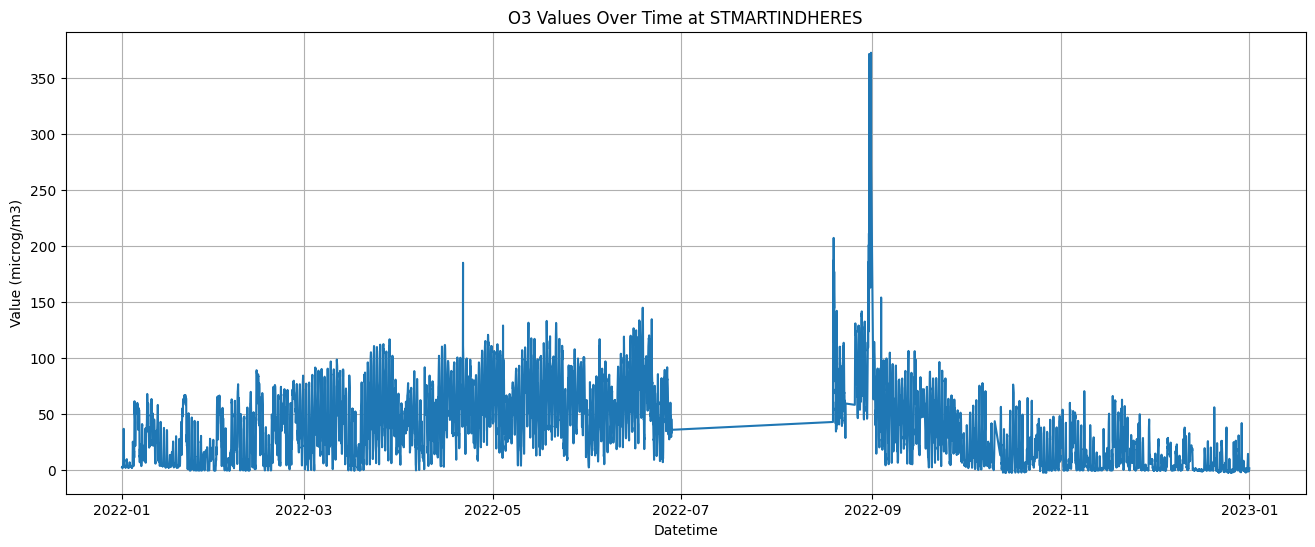

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(o3_df['datetime'], o3_df[target])
plt.title('O3 Values Over Time at STMARTINDHERES')
plt.xlabel('Datetime')
plt.ylabel('Value (microg/m3)')
plt.grid(True)
plt.show()

In [ ]:
o3_df.head()

,id_site,site,pol,pol_id,date,datetime,value,state,rawValue,rawState,unite,day_of_week,hour_of_day,minute_of_hour,month_of_year,year,day_of_month
3,15048,GRESIVAUDANPER,O3,8,2022-01-01T01:00:00Z,2022-01-01 01:00:00+00:00,2.8,1,2.8,A,microg/m3,5,1,0,1,2022,1
7,15048,GRESIVAUDANPER,O3,8,2022-01-01T02:00:00Z,2022-01-01 02:00:00+00:00,3.2,1,3.2,A,microg/m3,5,2,0,1,2022,1
11,15048,GRESIVAUDANPER,O3,8,2022-01-01T03:00:00Z,2022-01-01 03:00:00+00:00,2.4,1,2.4,A,microg/m3,5,3,0,1,2022,1
15,15048,GRESIVAUDANPER,O3,8,2022-01-01T04:00:00Z,2022-01-01 04:00:00+00:00,2.4,1,2.4,A,microg/m3,5,4,0,1,2022,1
19,15048,GRESIVAUDANPER,O3,8,2022-01-01T05:00:00Z,2022-01-01 05:00:00+00:00,2.8,1,2.8,A,microg/m3,5,5,0,1,2022,1


In [ ]:
o3_df.groupby('state').count()

,id_site,site,pol,pol_id,date,datetime,value,rawValue,rawState,unite,day_of_week,hour_of_day,minute_of_hour,month_of_year,year,day_of_month
state,,,,,,,,,,,,,,,,
0,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327
1,7231,7231,7231,7231,7231,7231,7231,7231,7231,7231,7231,7231,7231,7231,7231,7231


### 1.4 Saving the csv

In [9]:
o3_df.to_csv('data/15048_O3_2022_processed.csv', index=False)

## 2. Concatenating CSV

In [ ]:
def concatenate_csv_files(file_list, date_column='datetime', output_file='concatenated_files.csv'):
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Read and append each CSV file to the list of DataFrames
    for file in file_list:
        df = pd.read_csv(file)
        dfs.append(df)
    
    # Concatenate the DataFrames
    concatenated_df = pd.concat(dfs)
    
    # Sort the concatenated DataFrame by the specified date column
    concatenated_df.sort_values(date_column, inplace=True)
    
    # Save the concatenated and sorted DataFrame to a new CSV file
    concatenated_df.to_csv(output_file, index=False)
    
    print(f"Concatenation completed. Result saved to '{output_file}'.")

# Example usage:
file_list = ['file1.csv', 'file2.csv', 'file3.csv']  # Add your file names here
concatenate_csv_files(file_list)


## 3. Processing final 10 stations to submit

In [51]:
def to_processed_filename(original_filename):
    return original_filename.replace(".csv", "_processed.csv")

def to_original_filename(processed_filename):
    return processed_filename.replace("_processed.csv", ".csv")

In [56]:
# The station is Saint Martin d'Hères 15038
for file in ['data/07004_O3_2022.csv', 'data/15043_O3_2022.csv', 'data/20017_O3_2022.csv', 'data/20037_O3_2022.csv', 'data/20047_O3_2022.csv', 'data/27007_O3_2022.csv', 'data/29439_O3_2022.csv', 'data/33120_O3_2022.csv', 'data/36019_O3_2022.csv', 'data/36021_O3_2022.csv']:

    o3_rawdf = pd.read_csv(file, delimiter=';', decimal=',')

    state_to_keep = ['A', 'I']
    state_to_index = { 'A' : 1, 'P' : 1, 'O' : 1, 'R' : 1, 'I' : 0 }
    target = 'rawValue'

    o3_df = convert_date_to_datetime(o3_rawdf)

    o3_df = add_time_features(o3_df)
    o3_df = convert_object_to_numeric(o3_df, ['rawValue'])

    o3_df.to_csv(to_processed_filename(file), index=False)
